In [1]:
!pip install timm -q

In [3]:
# Setup And Library

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import timm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/CIFAR10_Challenge'
os.makedirs(save_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Mounted at /content/drive
✓ Device: cuda


Data Preparation

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomCrop(128, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_full = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# 80-10-10 splitting data
train_data, val_data = random_split(train_full, [45000, 5000],
                                     generator=torch.Generator().manual_seed(42))
test_data = torch.utils.data.Subset(test_data, range(5000))

print(f"✓ Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


✓ Train: 45000 | Val: 5000 | Test: 5000


In [5]:
#PRETRAINED
print("\n ResNet50 with ImageNet pretrained weights...")
model = timm.create_model('resnet50', pretrained=True, num_classes=10)
model = model.to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

scaler = torch.cuda.amp.GradScaler()


 ResNet50 with ImageNet pretrained weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Parameters: 23,528,522


/tmp/ipython-input-2546447243.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [6]:
#Training
criterion = nn.CrossEntropyLoss()

# Train classifier head only
for name, param in model.named_parameters():
    if 'fc' not in name:
      # Freeze everything except final layer train only final layer
        param.requires_grad = False

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=1e-3, weight_decay=0.01)

num_epochs_stage1 = 5
num_epochs_stage2 = 15
total_epochs = num_epochs_stage1 + num_epochs_stage2

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_stage1)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

In [7]:
def train_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += targets.size(0)
        correct += pred.eq(targets).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / len(loader), correct / total

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader, desc='Validation'):
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += targets.size(0)
        correct += pred.eq(targets).sum().item()

    return total_loss / len(loader), correct / total

In [8]:
#STAGE 1: Training classifier head only (5 epochs)

best_val_acc = 0

for epoch in range(num_epochs_stage1):
    print(f"\nEpoch {epoch+1}/{num_epochs_stage1}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'acc': val_acc
        }, f'{save_dir}/level1_best.pth')
        print(f"✓ Saved! Best: {val_acc*100:.2f}%")

# STAGE 2: Fine-tune entire model
print("\n" + "="*70)
print("STAGE 2: Fine-tuning entire model (15 epochs)")
print("="*70)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Lower learning rate for fine-tuning
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_stage2)

patience = 5
patience_counter = 0

for epoch in range(num_epochs_stage2):
    print(f"\nEpoch {num_epochs_stage1 + epoch + 1}/{total_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'acc': val_acc
        }, f'{save_dir}/level1_best.pth')
        print(f"✓ Saved! Best: {val_acc*100:.2f}%")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping!")
            break


Epoch 1/5


Training:   0%|          | 0/352 [00:00<?, ?it/s]/tmp/ipython-input-860749333.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-860749333.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


Train: 67.60% | Val: 72.56%
✓ Saved! Best: 72.56%

Epoch 2/5


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Train: 74.19% | Val: 74.86%
✓ Saved! Best: 74.86%

Epoch 3/5


Validation: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


Train: 75.52% | Val: 75.70%
✓ Saved! Best: 75.70%

Epoch 4/5


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]


Train: 76.38% | Val: 77.14%
✓ Saved! Best: 77.14%

Epoch 5/5


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.88it/s]


Train: 76.93% | Val: 76.08%

STAGE 2: Fine-tuning entire model (15 epochs)

Epoch 6/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Train: 86.72% | Val: 90.60%
✓ Saved! Best: 90.60%

Epoch 7/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.50it/s]


Train: 92.39% | Val: 92.98%
✓ Saved! Best: 92.98%

Epoch 8/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


Train: 94.32% | Val: 94.28%
✓ Saved! Best: 94.28%

Epoch 9/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Train: 95.48% | Val: 95.20%
✓ Saved! Best: 95.20%

Epoch 10/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


Train: 96.11% | Val: 95.40%
✓ Saved! Best: 95.40%

Epoch 11/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


Train: 96.73% | Val: 95.52%
✓ Saved! Best: 95.52%

Epoch 12/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


Train: 97.18% | Val: 95.62%
✓ Saved! Best: 95.62%

Epoch 13/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Train: 97.39% | Val: 96.08%
✓ Saved! Best: 96.08%

Epoch 14/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Train: 97.82% | Val: 96.16%
✓ Saved! Best: 96.16%

Epoch 15/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.35it/s]


Train: 97.98% | Val: 96.16%

Epoch 16/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]


Train: 98.12% | Val: 96.32%
✓ Saved! Best: 96.32%

Epoch 17/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Train: 98.29% | Val: 96.36%
✓ Saved! Best: 96.36%

Epoch 18/20


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Train: 98.43% | Val: 96.60%
✓ Saved! Best: 96.60%

Epoch 19/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.53it/s]


Train: 98.43% | Val: 96.38%

Epoch 20/20


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s]

Train: 98.41% | Val: 96.46%


In [9]:
checkpoint = torch.load(f'{save_dir}/level1_best.pth')
model.load_state_dict(checkpoint['model'])

test_loss, test_acc = validate(model, test_loader, criterion)

print("LEVEL 1")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Best Val Acc:  {best_val_acc*100:.2f}%")
print(f"Target:        85%+")
print(f"Status:        {'PASSED' if test_acc >= 0.85 else 'RETRY'}")

Validation:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-860749333.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 40/40 [00:04<00:00,  9.18it/s]

LEVEL 1
Test Accuracy: 96.34%
Best Val Acc:  96.60%
Target:        85%+
Status:        PASSED


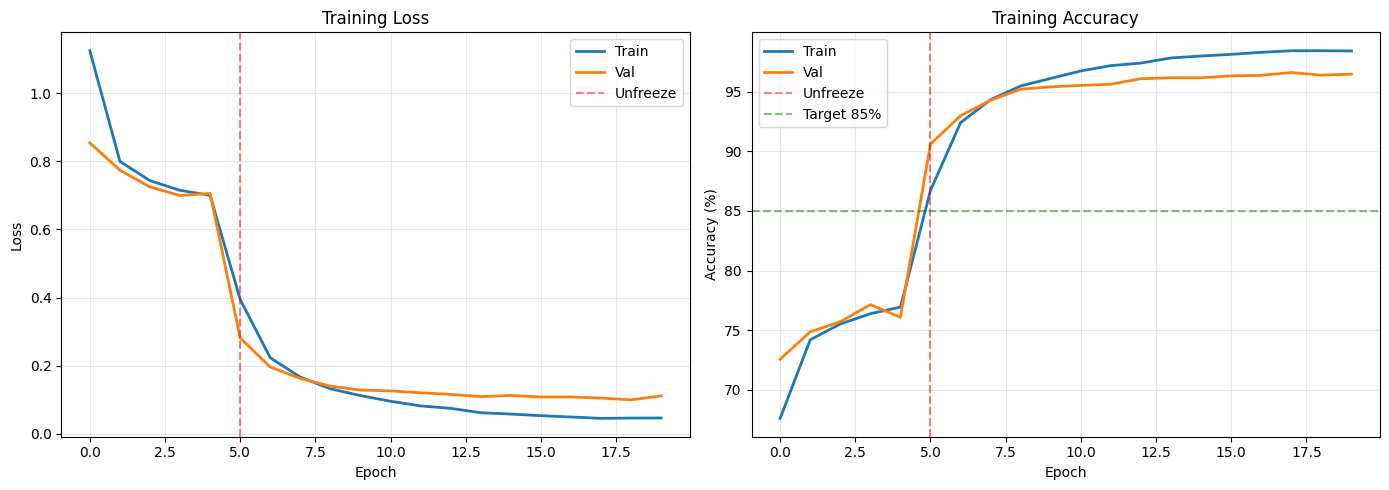


Per-class accuracy:
airplane    : 97.34%
automobile  : 97.82%
bird        : 97.07%
cat         : 91.95%
deer        : 96.06%
dog         : 93.24%
frog        : 98.57%
horse       : 97.37%
ship        : 97.82%
truck       : 96.49%


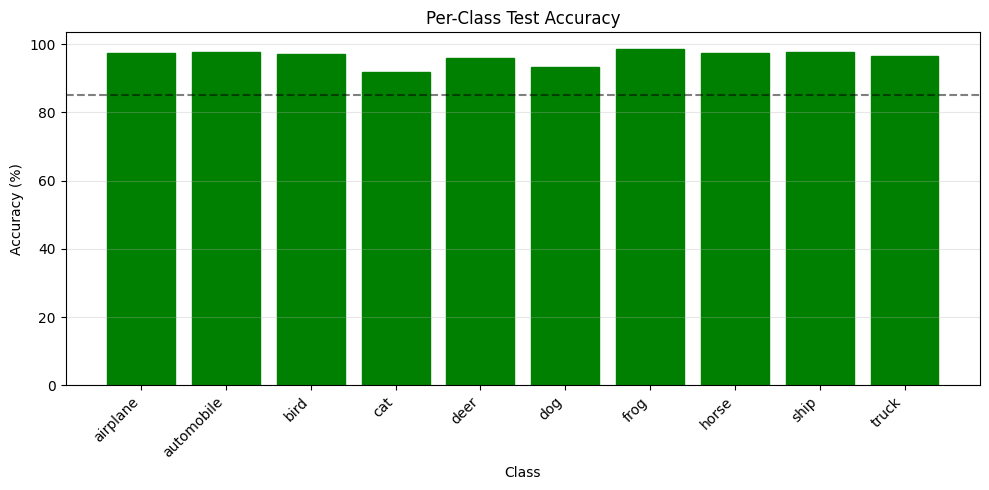

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].axvline(x=num_epochs_stage1, color='red', linestyle='--', alpha=0.5, label='Unfreeze')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot([a*100 for a in history['train_acc']], label='Train', linewidth=2)
axes[1].plot([a*100 for a in history['val_acc']], label='Val', linewidth=2)
axes[1].axvline(x=num_epochs_stage1, color='red', linestyle='--', alpha=0.5, label='Unfreeze')
axes[1].axhline(y=85, color='green', linestyle='--', alpha=0.5, label='Target 85%')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{save_dir}/level1_curves.png', dpi=150)
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, pred = outputs.max(1)

        for i in range(len(targets)):
            label = targets[i].item()
            class_correct[label] += (pred[i] == targets[i]).item()
            class_total[label] += 1

for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:12s}: {acc:5.2f}%")

plt.figure(figsize=(10, 5))
accs = [100 * class_correct[i] / class_total[i] for i in range(10)]
bars = plt.bar(classes, accs, color='steelblue')
for i, bar in enumerate(bars):
    if accs[i] >= 85:
        bar.set_color('green')
    elif accs[i] >= 75:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.axhline(y=85, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Test Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{save_dir}/level1_per_class.png', dpi=150)
plt.show()

In [11]:
summary = f"""
LEVEL 1 - COMPLETION SUMMARY
{'='*70}

Model: ResNet50 (Transfer Learning)
Strategy: Two-stage training (freeze → fine-tune)
Dataset: CIFAR-10 (80-10-10 split)

RESULTS:
Test Accuracy: {test_acc*100:.2f}%
Best Val Accuracy: {best_val_acc*100:.2f}%
Epochs Trained: {len(history['train_acc'])}

TARGET: 85%+
STATUS: {'PASSED' if test_acc >= 0.85 else 'NEEDS IMPROVEMENT'}

FILES SAVED:
- {save_dir}/level1_best.pth
- {save_dir}/level1_curves.png
- {save_dir}/level1_per_class.png

NEXT: Level 2 (Target 90%+)
{'='*70}
"""

with open(f'{save_dir}/level1_summary.txt', 'w') as f:
    f.write(summary)

print(summary)
print("\nLEVEL 1 COMPLETE!")


LEVEL 1 - COMPLETION SUMMARY

Model: ResNet50 (Transfer Learning)
Strategy: Two-stage training (freeze → fine-tune)
Dataset: CIFAR-10 (80-10-10 split)

RESULTS:
Test Accuracy: 96.34%
Best Val Accuracy: 96.60%
Epochs Trained: 20

TARGET: 85%+
STATUS: PASSED

FILES SAVED:
- /content/drive/MyDrive/CIFAR10_Challenge/level1_best.pth
- /content/drive/MyDrive/CIFAR10_Challenge/level1_curves.png
- /content/drive/MyDrive/CIFAR10_Challenge/level1_per_class.png

NEXT: Level 2 (Target 90%+)


LEVEL 1 COMPLETE!
